In [1]:
#data format library
import h5py
#numpy
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
# %matplotlib notebook
from sklearn.cluster import KMeans

import sys
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
import os
from scipy.integrate import odeint
#change path to where 'manuscript_data' is saved
dir_path = '/home/antonio/Repositories/manuscript_data/'
sys.path.append(dir_path+'/code/utils/')
import operator_calculations as op_calc
import worm_dynamics as worm_dyn
import stats

plt.rc('text', usetex=True)
plt.rc('font',size=14)

In [2]:
mat=h5py.File(dir_path+'/Foraging/ForagingData/PNAS2011-DataStitched.mat','r')

refs=list(mat['#refs#'].keys())[1:]
tseries_w=[ma.masked_invalid(np.array(mat['#refs#'][ref]).T)[:,:5] for ref in refs]
mat.close()
frameRate=16.
dt=1/frameRate

# Embedding 

In [3]:
f = h5py.File(dir_path+'Foraging/partition_combined_results_per_worm.h5','r')
K_range = np.array(f['K_range'],dtype=int)
seed_range = np.array(f['seed_range'],dtype=int)
prob_K_s = np.array(f['probs'])
H_K_s = np.array(f['entropies'])
h_K_s = np.array(f['entropy_rates'])
Ipred_K_s = np.array(f['Ipreds'])
eps_K_s = np.array(f['eps_scale'])
f.close()

In [4]:
def std_bootstrap(l,n_times): 
    new_means = []
    for i in range(n_times):
        indices=np.random.choice(range(0,len(l)),len(l))#len(l))
        new_list=[l[idx] for idx in indices]
        new_means.append(ma.mean(new_list,axis=0))
    new_means=ma.vstack(new_means)
    std = ma.std(new_means,axis=0)
    return ma.mean(l,axis=0),std

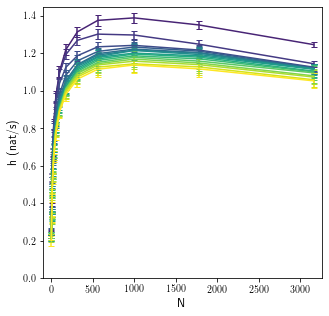

In [5]:
plt.figure(figsize=(5,5))
colors_K = plt.cm.viridis(np.linspace(.1,1,len(K_range[:30][::2])))
for k,K in enumerate(K_range[:30][::2]):
    mean,std = std_bootstrap(h_K_s[K-1,:13,:].T,n_times=5000)
    plt.errorbar(seed_range[:13],mean,std,c=colors_K[k],capsize=3)
plt.xlim(-100,seed_range[12]+100)
plt.ylim(0,1.45)
plt.xlabel('N',fontsize=12)
plt.ylabel('h (nat/s)',fontsize=12)
# plt.savefig('h_N_Foraging_2K.pdf')
plt.show()

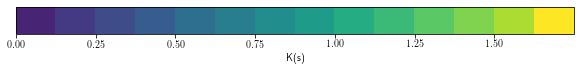

In [6]:
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(10, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.colors.ListedColormap(colors_K)
cmap.set_over('0.1')
cmap.set_under('1.0')

bounds =  (K_range[:30][::2]-1)*dt
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                boundaries=bounds,
                                ticks=np.arange(0,1.6,.25),
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('K(s)')
# plt.savefig('colorbar_K_range_h_2K.pdf')
fig.show()


In [7]:
from sklearn.linear_model import LinearRegression


ks=10 # 1000 clusters
x = 1/(K_range[1:16].reshape(-1,1)*dt)
y = np.mean(h_K_s[1:16,ks,:],axis=1)
reg = LinearRegression().fit(x,y)
R2= reg.score(x,y)
print(R2)
m_mean = reg.coef_[0]
b_mean = reg.intercept_

mean_h = b_mean

#bootstrap h_infty
n_times = 1000
h_asymp = np.zeros(n_times)
slope_asymp = np.zeros(n_times)
for k in range(1000):
    x = 1/(K_range[1:16].reshape(-1,1)*dt)
    y = np.mean(h_K_s[1:16,ks,np.random.randint(0,12,12)],axis=1)
    reg = LinearRegression().fit(x,y)
    R2= reg.score(x,y)

    m = reg.coef_[0]

    b = reg.intercept_
    slope_asymp[k] = m
    h_asymp[k] = b
cil_h = np.percentile(h_asymp,2.5)
ciu_h = np.percentile(h_asymp,97.5)

0.9884109381373235


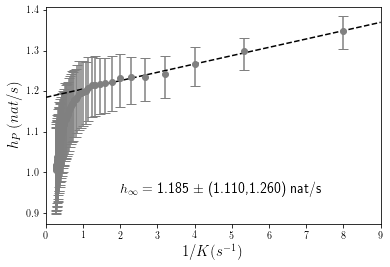

In [8]:
mean,cil,ciu = stats.bootstrap(h_K_s[1:,ks].T,n_times=100)

plt.errorbar(1/(K_range[1:]*dt),mean[:],[mean[:]-cil[:],ciu[:]-mean[:]],capsize=5,c='gray',fmt='o')
plt.plot(np.arange(0,10),m_mean*np.arange(0,10)+b_mean,ls='--',c='k')
plt.ylabel('$h_P\, (nat/s)$',fontsize=15)
plt.xlabel('$1/K (s^{-1})$',fontsize=15)
plt.xlim(0,9)
plt.text(2,0.95,'$h_\infty = $ {:.3f} $\pm$ ({:.3f},{:.3f}) nat/s'.format(mean_h,cil_h,ciu_h),fontsize=14)
plt.show()

# Time Scales

In [4]:
n_clusters=1000
f = h5py.File(dir_path+'Foraging/tscales_per_worm/tscales_compute_{}_clusters.h5'.format(n_clusters),'r')
ts_traj_delay = np.array(f['ts_traj_delay'])
delay_range = np.array(f['delay_range'])
length = int(np.array(f['seq_length'])[0])
f.close()

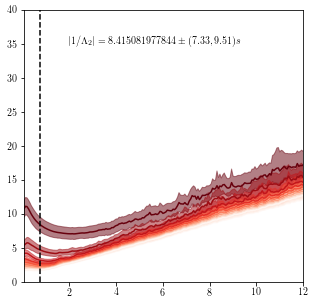

In [10]:
n_modes=10
plt.figure(figsize=(5,5))
colors_ = plt.cm.Reds_r(np.linspace(0,1,n_modes))

for mode in range(n_modes):
    mean,cil,ciu=stats.bootstrap(ts_traj_delay[:,:,mode],median=False,n_times=1000)
    plt.plot(delay_range*dt,mean,c=colors_[mode])
    plt.fill_between(delay_range*dt,cil,ciu,alpha=.5,color=colors_[mode])
mean,cil,ciu=stats.bootstrap(ts_traj_delay[:,:,0],median=False,n_times=1000)
plt.text(2,35,r'$|1/\Lambda_2| = {:.12f}\pm({:.2f},{:.2f}) s$'.format(mean[11],cil[11],ciu[11]))
plt.axvline(delay_range[11]*dt,c='k',ls='--')
plt.xlim(dt,12)
plt.ylim(0,40)
# plt.savefig('tscales_Foraging_1000_clusters.pdf')
plt.show()


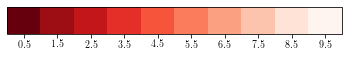

In [11]:
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.colors.ListedColormap(colors_)
cmap.set_over('0')
cmap.set_under('1.0')

bounds = np.arange(0,n_modes+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                boundaries=bounds,
                                ticks=bounds-.5,
                                spacing='proportional',
                                orientation='horizontal')
# plt.savefig('discrete_cbar_mode_range_Foraging.pdf')
fig.show()


In [12]:
eigvals_traj_delay = np.copy(ts_traj_delay)
for traj_idx in range(ts_traj_delay.shape[0]):
    eigvals_traj_delay[traj_idx,:,:] = np.exp(-(delay_range*dt)/ts_traj_delay[traj_idx,:,:].T).T

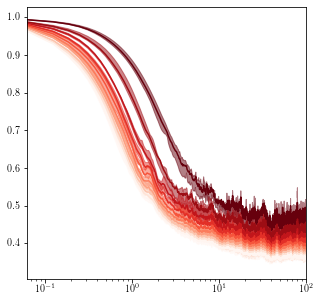

In [13]:
n_modes=10
colors_ = plt.cm.Reds_r(np.linspace(0,1,n_modes))

plt.figure(figsize=(5,5))
for mode in range(n_modes):
    mean,cil,ciu=stats.bootstrap(eigvals_traj_delay[:,:,mode],n_times=5)
    plt.plot(delay_range*dt,mean,c=colors_[mode])
    plt.fill_between(delay_range*dt,cil,ciu,alpha=.5,color=colors_[mode])
plt.xscale('log')
plt.xlim(dt,100)
# plt.ylim(.4,1)

# plt.axhline(max_eig_random.mean(),ls='--',c='gray')
# plt.axhline(np.percentile(,c='gray')
# plt.savefig('eigvals_Foraging_1000_clusters.pdf')
plt.show()

In [14]:
# n_modes = ts_traj_delay.shape[2]
# part_ratio_traj = np.zeros(eigvals_traj_delay.shape[:2])
# for traj_idx in range(ts_traj_delay.shape[0]):
#     part_ratio_traj[traj_idx] = (np.nansum(eigvals_traj_delay[traj_idx],axis=1)**2/np.nansum(eigvals_traj_delay[traj_idx]**2,axis=1))/n_modes

In [15]:
# mean,cil,ciu = stats.bootstrap(part_ratio_traj,n_times=1000)
# plt.plot(delay_range*dt,mean)
# plt.fill_between(delay_range*dt,cil,ciu,alpha=.5)
# # plt.xlim(delay_range[0]*dt,delay_range[-1]*dt)
# plt.xscale('log')
# plt.ylim(0.92,1)
# # plt.savefig('part_ratio_1000_clusters.pdf')
# plt.show()